a1 = 1, a2 = 0, lamda0 negative, with newton method

In [14]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
# viscosity = .01/pi

# Define initial condition
# def fun_u_0(x):
#     return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
# # parameter
# R0 = 0.95
# k0 = 2.2
# q0 = 1.1
# B0 = 0.5
# phib = 0.09
# c0 = B0/(R0**2*k0*q0)
# c1 = B0*(k0**2+1)/(R0**2*k0*q0)
# c2 = 0
a1 = 1
a2 = 0
eta = 0.005
def fun_r(r, z, lamda_i, phi_i, phi_r, phi_rr, phi_z, phi_zz):
    # return -lamda_i*(a1+a2*r**2)*phi_i + phi_rr - phi_r/r + phi_zz
    return -lamda_i*r**2*(2*a2*(1-tf.exp(-phi_i**2/eta)) + 2/eta*(a1 + a2*phi_i**2)*tf.exp(-phi_i**2/eta))*phi_i + phi_rr - phi_r/r + phi_zz

Generate collocation points

In [15]:
# Set number of data points
N_0 = 50
N_b = 200
N_r = 1000

# parameter
# R0 = 0.95
# k0 = 2.2
# q0 = 1.1
# B0 = 0.5
# phib = 0.09
# c0 = B0/(R0**2*k0*q0)
# c1 = B0*(k0**2+1)/(R0**2*k0*q0)
# c2 = 0

# Set boundary
eps = 0.32
# eps = 0.78
kappa = 1.7
# kappa = 2.0
# a = 0.336
a = np.arcsin(0.33)
print('d= ', np.sin(a))
phib = 0.0
t0 = tf.reshape(tf.linspace(0.0,2*pi,N_b), [N_b,1])
r_b = 1+eps*tf.cos(t0 + a*tf.sin(t0))
z_b = eps*kappa*tf.sin(t0)
# zmin = -1.
# zmax = 1.

# Lower bounds
rmin = min(r_b)
rmax = max(r_b)
lb = tf.constant(rmin, dtype=DTYPE)
# Upper bounds
ub = tf.constant(rmax, dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
# r_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
# z_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
# X_0 = tf.concat([r_0, z_0], axis=1)

# Evaluate intitial condition at x_0
# u_0 = fun_u_0(x_0)
# r_bound = tf.constant([rmin, rmax], dtype=DTYPE)
# z_bound = 1/r_bound*tf.sqrt(alpha**2 - k0**2/4*(r_bound**2-R0**2)**2)
# Boundary data
# r_b = tf.random.uniform((N_b,1), lb, ub, dtype=DTYPE)
# z_b = 1/r_b*tf.sqrt(alpha**2 - k0**2/4*(r_b**2-R0**2)**2)
X_b = tf.concat([r_b, z_b], axis=1)
# X_b_n = tf.concat([r_b, -z_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
phi_b = phib*tf.ones((len(z_b),1))
# phi_b_n = phib*tf.ones((len(z_b),1))


# Draw uniformly sampled collocation points
r_r = tf.random.uniform((N_r,1), lb, ub, dtype=DTYPE)
z_r = tf.convert_to_tensor(np.interp(r_r, r_b.numpy()[int(N_b/2):,0], z_b.numpy()[int(N_b/2):,0]), dtype=DTYPE)
z_r = z_r + tf.math.multiply(tf.random.uniform((len(r_r),1), 0, 1, dtype=DTYPE)*2,(-z_r))
X_r = tf.concat([r_r, z_r], axis=1)

# # Collect boundary and inital data in lists
X_data = [X_b]
phi_data = [phi_b]

d=  0.33


C:\Users\asus\AppData\Local\Temp\ipykernel_17904\1250455613.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(r_b, z_b, c='b', marker='X', vmin=-1, vmax=1)


Text(0.5, 1.0, 'Positions of collocation points and boundary data')

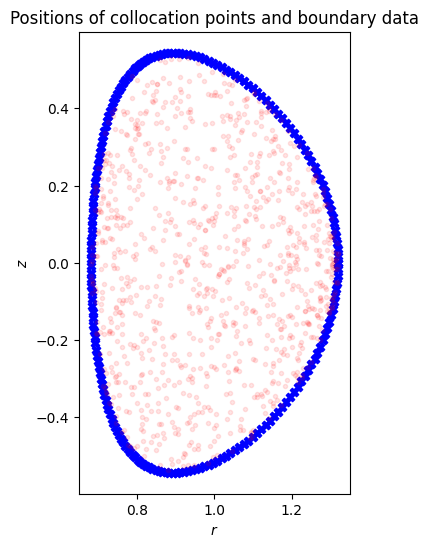

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
# plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(r_b, z_b, c='b', marker='X', vmin=-1, vmax=1)
# plt.scatter(r_b, -z_b, c=phi_b_n, marker='X', vmin=-1, vmax=1)
plt.scatter(r_r, z_r, c='r', marker='.', alpha=0.1)
# plt.scatter(r_bound, z_bound, marker='o')
plt.xlabel('$r$')
plt.ylabel('$z$')
plt.axis('scaled')
plt.title('Positions of collocation points and boundary data')

In [17]:
import random
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)
    # act_list = [tf.keras.activations.get('tanh'), tf.keras.activations.get('relu'), tf.keras.activations.get('mish'), tf.keras.activations.get('silu')]
    # Append hidden layers
    for _ in range(num_hidden_layers):
        # act_func = random.choice(act_list)
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('silu'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

In [18]:
def get_r(model, X_r, lamda_i, phi_i):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        r, z = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(r)
        tape.watch(z)

        # Determine residual 
        phi = model(tf.stack([r[:,0], z[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        phi_r = tape.gradient(phi, r)
        phi_z = tape.gradient(phi, z)
            
    # u_t = tape.gradient(u, t)
    phi_rr = tape.gradient(phi_r, r)
    phi_zz = tape.gradient(phi_z, z)

    del tape

    return fun_r(r, z, lamda_i, phi_i, phi_r, phi_rr, phi_z, phi_zz)

In [19]:
def compute_loss(model, X_r, X_data, phi_data, lamda_i, phi_i):
    
    # Compute phi^r
    r = get_r(model, X_r, lamda_i, phi_i)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        phi_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(phi_data[i] - phi_pred))
    
    return loss

In [20]:
def get_grad(model, X_r, X_data, phi_data, lamda_i, phi_i):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, phi_data, lamda_i, phi_i)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [21]:
# Initialize model aka u_\theta
model = init_model(10,50)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.legacy.Adam(learning_rate=lr)

In [22]:
def grad_hessian_model(model, x0):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        r, z = x0[:,0:1], x0[:,1:]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(r)
        tape.watch(z)

        # Determine residual 
        phi = model(tf.stack([r[:,0], z[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        phi_r = tape.gradient(phi, r)
        phi_z = tape.gradient(phi, z)
            
    # u_t = tape.gradient(u, t)
    phi_rr = tape.gradient(phi_r, r)
    phi_zz = tape.gradient(phi_z, z)
    phi_rz = tape.gradient(phi_r, z)
    phi_zr = tape.gradient(phi_z, r)

    del tape

    hess_1 = tf.stack([phi_rr[0,:], phi_rz[0,:]], axis=0)
    hess_2 = tf.stack([phi_zr[0,:], phi_zz[0,:]], axis=0)

    return tf.stack([phi_r[0,:], phi_z[0,:]], axis=0), tf.stack([hess_1[:,0], hess_2[:,0]], axis=1)

In [23]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step(lamda_i, phi_i):
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, phi_data, lamda_i, phi_i)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

def infty_norm(x):
    return np.max(np.abs(x))


def newton_method(model, x0, eps):
    arr_x = [x0]
    err = [np.inf]
    for i in range(100):
        grad, hess = grad_hessian_model(model, arr_x[-1])
        arr_x.append(arr_x[-1] - tf.transpose(tf.matmul(tf.linalg.inv(hess),grad)))
        err.append(infty_norm(grad))
        if err[-1] < 1e-4:
            print('newton method succeed')
            break
    return arr_x[-1]

# Number of training epochs
N = 10000

lamda0 = 10.0
base_model = tf.keras.models.load_model('saved_model/linear_rhs_1_0')
phi0 = base_model(X_r)
arr_lamda = [lamda0]
arr_phi = [phi0]

# Start timer
for j in range(10):
    t0 = time()
    hist = []
    for i in range(N+1):
        
        loss = train_step(arr_lamda[-1], arr_phi[-1])
        
        # Append current loss to hist
        hist.append(loss.numpy())
        
        # Output current loss after 50 iterates
        if i%50 == 0:
            print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        if i > 100:
            if (np.abs(np.diff(np.array(hist)))[-100:] < 2e-6).all():
                print('stop iteration for j=',j,' is ',i)
                break
    if loss < 3e-2:
        phi_est = model(X_r)
        norm_phi = infty_norm(phi_est)
        argmin, min_val = np.argmin(phi_est), np.min(phi_est)
        argmax, max_val = np.argmax(phi_est), np.max(phi_est)
        if abs(min_val) > abs(max_val):
            x0 = X_r[argmin:argmin+1]
            sign = -1
        else:
            x0 =X_r[argmax:argmax+1]
            sign = 1
        arg_norm_phi = newton_method(model, x0, 1e-3)
        norm_phi = model(arg_norm_phi)
        norm_phi = sign*norm_phi[0,0].numpy()
        arr_phi.append(phi_est/norm_phi)
        arr_lamda.append(arr_lamda[-1]/norm_phi)
        arr_lamda[-1] = arr_lamda[-1].astype('float32')
        print('lamda-', j,': ', arr_lamda[-1])
        print('norm phi: ', norm_phi)
    else:
        print('failed')
        break
            
    # Print computation time
    print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.41622986e+03
It 00050: loss = 1.41127747e+03
It 00100: loss = 1.21376428e+03
It 00150: loss = 1.40872925e+03
It 00200: loss = 1.36404126e+03
It 00250: loss = 1.18749341e+03
It 00300: loss = 1.18367346e+03
It 00350: loss = 1.11611572e+03
It 00400: loss = 1.37948010e+03
It 00450: loss = 1.24480579e+03
It 00500: loss = 1.15187988e+03
It 00550: loss = 1.39681543e+03
It 00600: loss = 1.41729382e+03
It 00650: loss = 1.39910339e+03
It 00700: loss = 1.43752734e+03
It 00750: loss = 1.14362134e+03
It 00800: loss = 9.75785645e+02
It 00850: loss = 1.27285706e+03
It 00900: loss = 8.73911560e+02
It 00950: loss = 8.13180908e+02
It 01000: loss = 4.56272797e+02
It 01050: loss = 1.78450043e+02
It 01100: loss = 9.78591690e+01
It 01150: loss = 6.25699730e+01
It 01200: loss = 4.17141342e+01
It 01250: loss = 2.94445000e+01
It 01300: loss = 2.21997452e+01
It 01350: loss = 1.75052643e+01
It 01400: loss = 1.42033920e+01
It 01450: loss = 1.18260021e+01
It 01500: loss = 1.01012030e+01
It 01550

In [24]:
x0

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.91856545, 0.15628809]], dtype=float32)>

In [25]:
for i in range(len(arr_phi)-1):
    if i%1 == 0:
        plt.plot(arr_phi[i]-arr_phi[i+1])
        print(np.average(np.abs(arr_phi[i]-arr_phi[i+1])))
    

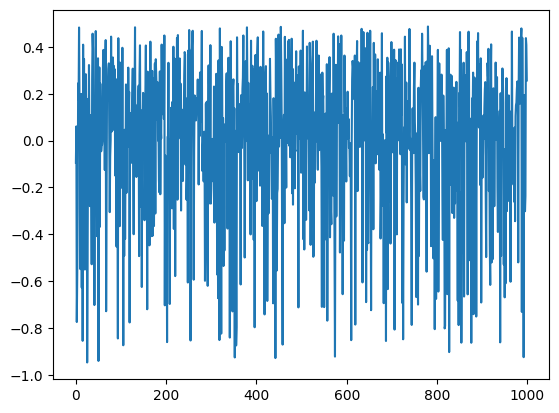

In [26]:
plt.plot(arr_phi[-1])

Text(0.5, 0.92, 'Solution of GS equation')

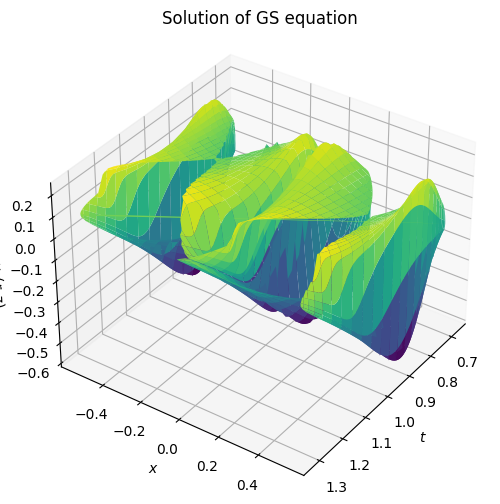

In [27]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = int(N_b/2)
rspace = r_b[int(N_b/2):,0]
zspace = z_b[int(N_b/2):,0]
R, Z = np.meshgrid(rspace, zspace)
Xgrid = np.vstack([R.flatten(),Z.flatten()]).T
Xgrid = np.concatenate((Xgrid, np.vstack([R.flatten(),-Z.flatten()]).T), axis=0)
ineq = np.abs(Xgrid[:,1]) < -np.array([zspace[rspace == Xgrid[i,0]][0] for i in range(len(Xgrid))])
# Xgrid = Xgrid[ineq]

# Determine predictions of u(t, x)
phipred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
phi = phipred.numpy().reshape(N,2*N)
ineq = ineq.reshape(N,2*N)
R_ax = Xgrid[:,0].reshape(N,2*N)
Z_ax = Xgrid[:,1].reshape(N,2*N)
phi[~ineq] = np.nan

total_R = np.concatenate((R,R),axis=1)
total_Z = np.concatenate((Z, -Z),axis=1)

# # Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(total_R, total_Z, phi, cmap='viridis')
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\phi(r,z)$')
ax.set_title('Solution of GS equation')
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

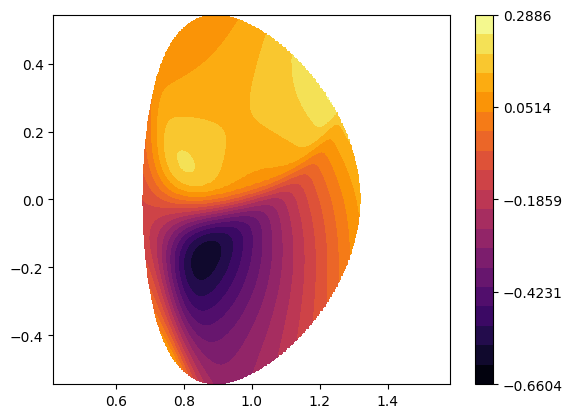

In [28]:
min_phi = np.nanmin(phi.flatten())
max_phi = np.nanmax(phi.flatten())
levels1 = np.linspace(min_phi - abs(min_phi)*0.1, max_phi + abs(max_phi)*0.2,20)
level_ticks = np.linspace(min_phi - abs(min_phi)*0.1, max_phi + abs(max_phi)*0.2,5)
fig = plt.contourf(R_ax, Z_ax, phi, levels1, cmap='inferno')
plt.axis('equal')
plt.colorbar(fig, ticks=level_ticks)

C:\Users\asus\AppData\Local\Temp\ipykernel_17904\2953584796.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(r_b, z_b, c='b', marker='X', vmin=-1, vmax=1)


(0.6480184733867645,
 1.3519990503787995,
 -0.5983813464641571,
 0.5983813464641571)

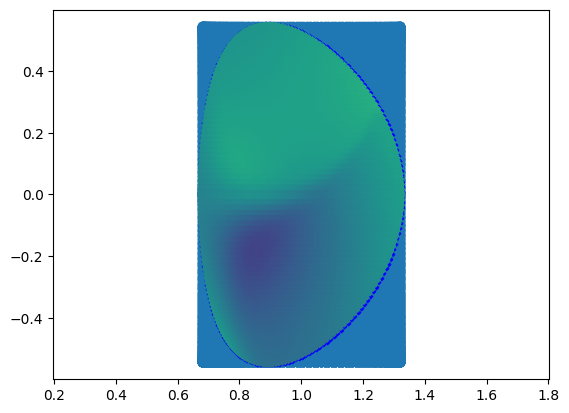

In [29]:
plt.scatter(total_R,total_Z)
plt.scatter(r_b, z_b, c='b', marker='X', vmin=-1, vmax=1)
# plt.scatter(r_b, -z_b, c='b', marker='X', vmin=-1, vmax=1)
plt.scatter(R_ax, Z_ax, c=phi, marker='X', vmin=-1, vmax=1)

plt.axis('equal')

Text(0, 0.5, '$\\phi_{n_{epoch}}$')

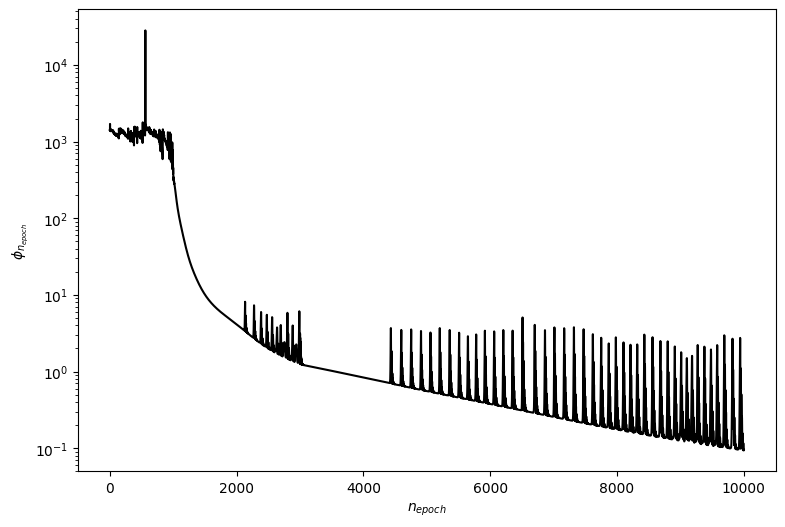

In [30]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')

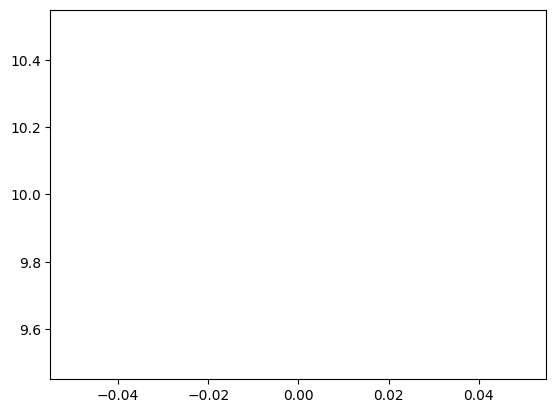

In [31]:
plt.plot(arr_lamda)

Loss per point

In [32]:
def compute_loss_inner(model, X_r, lamda_i, phi_i):
    
    # Compute phi^r
    r = get_r(model, X_r, lamda_i, phi_i)
    phi_r = tf.square(r)
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    # for i in range(len(X_data)):
    #     phi_pred = model(X_data[i])
    #     loss += tf.reduce_mean(tf.square(phi_data[i] - phi_pred))
    
    return loss.numpy()

def compute_loss_data(model, X_data, phi_data):
    
    # Compute phi^r
    # r = get_r(model, X_r)
    # phi_r = tf.square(r)
    
    # Initialize loss
    loss = []
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(phi_data)):
        phi_pred = model(X_data[i])
        loss.append(tf.square(phi_data[i] - phi_pred).numpy())
        # print(tf.square(phi_data[i] - phi_pred).numpy())
    return loss

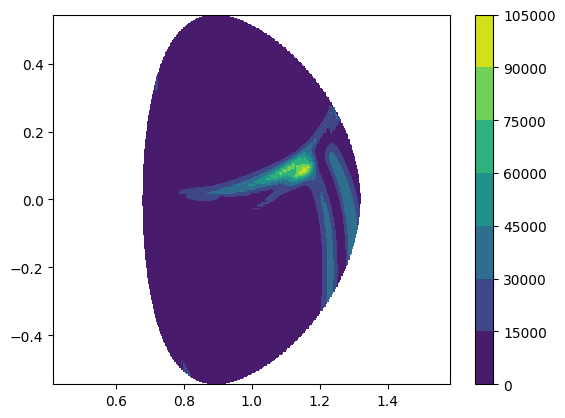

In [33]:
Xgrid_tensor =  tf.convert_to_tensor(Xgrid)
err = compute_loss_inner(model,Xgrid_tensor, arr_lamda[-1], model(Xgrid_tensor))
err = err.reshape(N, 2*N)
err[~ineq] = np.nan
plt.contourf(R_ax, Z_ax, err)
plt.axis('equal')
plt.colorbar()

In [34]:
err = compute_loss_inner(model, X_r, arr_lamda[-1], arr_phi[-1])
err

array([[2.21249104e-01],
       [1.11896202e-01],
       [3.37112159e-03],
       [1.67954918e-02],
       [3.28127899e-05],
       [8.39888379e-02],
       [3.18909176e-02],
       [6.14017155e-03],
       [3.41600826e-04],
       [4.08956148e-02],
       [2.57640537e-02],
       [3.36093865e-02],
       [2.79106025e-04],
       [8.62686243e-03],
       [4.46406938e-02],
       [1.17046863e-03],
       [3.18491645e-02],
       [7.16103023e-06],
       [1.96863078e-02],
       [4.89995728e-05],
       [3.20262015e-01],
       [5.51597059e-01],
       [1.76658912e-03],
       [1.08716321e+00],
       [5.51635312e-05],
       [5.23148861e-04],
       [3.20131890e-02],
       [4.01403336e-03],
       [9.65173356e-03],
       [6.72385886e-06],
       [9.34480131e-02],
       [3.97064770e-03],
       [4.12434951e-04],
       [9.65140089e-02],
       [5.42458612e-03],
       [1.02351591e-01],
       [6.20733044e-05],
       [1.35937892e-02],
       [2.32372491e-04],
       [1.41832426e-01],


In [35]:
compute_loss_data(model, X_data, phi_data)

[array([[1.03623345e-02],
        [1.13062039e-02],
        [1.22692240e-02],
        [1.32528460e-02],
        [1.42558245e-02],
        [1.52764609e-02],
        [1.63134336e-02],
        [1.73650011e-02],
        [1.84236430e-02],
        [1.94694698e-02],
        [2.04693265e-02],
        [2.13970859e-02],
        [2.22560409e-02],
        [2.30087377e-02],
        [2.36471463e-02],
        [2.65288278e-02],
        [3.87797318e-02],
        [5.46546876e-02],
        [5.93497939e-02],
        [5.89600578e-02],
        [5.78549169e-02],
        [5.63544556e-02],
        [5.45094758e-02],
        [5.23374118e-02],
        [4.98868413e-02],
        [4.72428389e-02],
        [4.44837175e-02],
        [4.16659899e-02],
        [3.88285294e-02],
        [3.60027142e-02],
        [3.32169831e-02],
        [3.04979850e-02],
        [2.78707463e-02],
        [2.53552534e-02],
        [2.29669847e-02],
        [2.07159705e-02],
        [1.86077859e-02],
        [1.66444015e-02],
        [1.4

In [36]:
def nabla_phi(model, X_r):
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        r, z = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(r)
        tape.watch(z)

        # Determine residual 
        phi = model(tf.stack([r[:,0], z[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
    phi_r = tape.gradient(phi, r)
    phi_z = tape.gradient(phi, z)

    del tape
    return np.concatenate([phi_r.numpy(), np.zeros((len(X_r),1)), phi_z.numpy()],axis=1)
    

In [37]:
a = np.cross(nabla_phi(model, X_r)/X_r[:,0:1].numpy(),np.array([0,1,0]))